In [63]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/drive/MyDrive/PTKD/VPB.csv')
df=df.reset_index()['Price']
df

0       10676.9
1       10687.7
2       10698.5
3       11195.6
4       11498.2
         ...   
1246    19450.0
1247    19300.0
1248    19400.0
1249    19850.0
1250    19750.0
Name: Price, Length: 1251, dtype: float64

In [65]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df).reshape(-1,1))

In [66]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [67]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [68]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [69]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [70]:


# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [71]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
11/11 [==============================] - 3s 49ms/step - loss: 0.0356 - val_loss: 0.1096
Epoch 2/100
11/11 [==============================] - 0s 16ms/step - loss: 0.0126 - val_loss: 0.0254
Epoch 3/100
11/11 [==============================] - 0s 17ms/step - loss: 0.0031 - val_loss: 0.0013
Epoch 4/100
11/11 [==============================] - 0s 17ms/step - loss: 7.3547e-04 - val_loss: 0.0156
Epoch 5/100
11/11 [==============================] - 0s 12ms/step - loss: 5.2061e-04 - val_loss: 0.0016
Epoch 6/100
11/11 [==============================] - 0s 17ms/step - loss: 4.3730e-04 - val_loss: 0.0018
Epoch 7/100
11/11 [==============================] - 0s 16ms/step - loss: 3.7261e-04 - val_loss: 0.0037
Epoch 8/100
11/11 [==============================] - 0s 17ms/step - loss: 3.6589e-04 - val_loss: 0.0025
Epoch 9/100
11/11 [==============================] - 0s 16ms/step - loss: 3.7241e-04 - val_loss: 0.0032
Epoch 10/100
11/11 [==============================] - 0s 12ms/step - loss: 3

In [72]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

1/1 [==============================] - 0s 31ms/step


In [73]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [74]:
train_size1 = int(0.6 * len(df))
test_size1 = int(0.3 * len(df))

train_data1 = df[:train_size1]
test_data1 = df[train_size1:train_size1+test_size1]
val_data1 = df[train_size1+test_size1:]

# re make predictions on the testing set
x_test1 = np.array(test_data1.index).reshape(-1, 1)
y_test1 = np.array(test_data1)

# re make predictions on the validate set
x_val1 = np.array(val_data1.index).reshape(-1, 1)
y_val1 = np.array(val_data1)


In [75]:
# 11. Đánh giá độ chính xác thuật toán
#RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val1)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test1)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

#MAPE
valid_mape = np.mean(np.abs((y_val1 - y_pred_val) / y_val1)) * 100
test_mape = np.mean(np.abs((y_test1 - y_pred) / y_test1)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

#MAE
valid_mae = np.mean(np.abs(y_pred_val - y_val1))
test_mae = np.mean(np.abs(y_pred - y_test1))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation RMSE: 1526.9033213669272
Testing RMSE: 4384.667487175489
Validation MAPE: 6.6962946316432275
Testing MAPE: 16.61078198487809
Validation MAE: 1210.6156262400793
Testing MAE: 3511.9807520757295


In [77]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=66
i=0
while(i<30):

    if(len(temp_input)>66):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.6619488]
67
1 day input [0.53380407 0.5192751  0.52411809 0.53864706 0.57496949 0.57739098
 0.58223397 0.63550687 0.63550687 0.65487883 0.63792836 0.65003584
 0.65003584 0.68151527 0.71299471 0.71541621 0.7202592  0.72510219
 0.71299471 0.70815172 0.70815172 0.71541621 0.72268069 0.73236667
 0.72268069 0.70815172 0.70815172 0.70815172 0.71299471 0.69604425
 0.69362275 0.68877976 0.68635827 0.67667228 0.65003584 0.63308537
 0.63792836 0.64034986 0.63066388 0.63308537 0.63550687 0.65972182
 0.64277135 0.63792836 0.63792836 0.63792836 0.64277135 0.65487883
 0.65245733 0.65487883 0.64519285 0.62582089 0.62824238 0.63066388
 0.65003584 0.64277135 0.63550687 0.62582089 0.62339939 0.63308537
 0.63792836 0.63066388 0.63550687 0.65730032 0.65245733 0.6619488 ]
1 day output [[0.66846526]]
2 day input [0.5192751  0.52411809 0.53864706 0.57496949 0.57739098 0.58223397
 0.63550687 0.63550687 0.65487883 0.63792836 0.65003584 0.65003584
 0.68151527 0.71299471 0.71541621 0.7202592  0.72510219 0.712

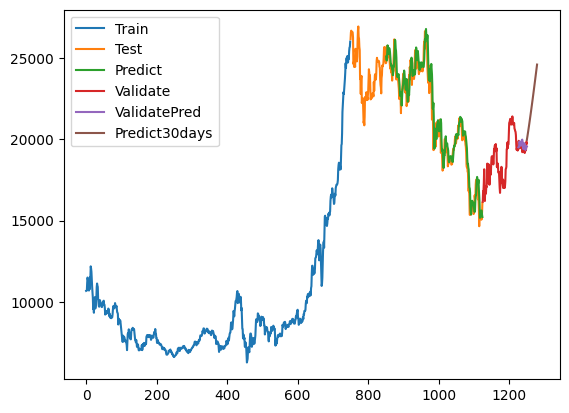

In [78]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()